In [87]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from PIL import Image
import numpy as np
import sys
import math
import os
import time
from collections import OrderedDict

import torch
from torch import nn
from torch.autograd import Variable, Function
from torchvision import models, transforms
import torchvision.models as models
import torchvision.datasets as datasets

%matplotlib inline

print("mpl backend: ", plt.get_backend())

mpl backend:  module://ipykernel.pylab.backend_inline


In [3]:
torch.cuda.set_device(3)

In [4]:
classifier_size = 512 * 2 * 2

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(classifier_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'LITTLE': [32, 'M', 64, 'M', 128, 128, 'M', 256, 256, 'M', 256, 256, 'M']
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict( model_zoo.load_url(model_urls['vgg11']))
    return model


def vgg11_little(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=False), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model

In [5]:
vgg_pretrained = vgg11_little(num_classes=200)
vgg_pretrained = vgg_pretrained.cuda()
resume='model_best.pth.tar'
if os.path.isfile(resume):
    print("=> loading checkpoint '{}'".format(resume))
    checkpoint = torch.load(resume)
    start_epoch = checkpoint['epoch']
    best_prec1 = checkpoint['best_prec1']
    vgg_pretrained.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(resume, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume))

=> loading checkpoint 'model_best.pth.tar'
=> loaded checkpoint 'model_best.pth.tar' (epoch 2)


In [100]:
classifier_size = 512 * 2 * 2

class vgg_conv(torch.nn.Module):

    def __init__(self, features, m_classes=1000):
        super(vgg_conv, self).__init__()
        # VGG16 (using return_indices=True on the MaxPool2d layers)
        self.features = torch.nn.Sequential(
            # conv1
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv2
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv3
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv4
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv5
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True))
        self.feature_outputs = [0]*len(self.features)
        self.pool_indices = dict()

        self.classifier = vgg_pretrained.classifier
        self._initialize_weights()


    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg_pretrained.features):
            print("initializing layer {}: {}".format(i, layer))
            try:
                self.features[i].weight.data = layer.weight.data
                self.features[i].bias.data = layer.bias.data
            except:
                continue

    def get_conv_layer_indices(self):
        return [0, 3, 6, 8, 11, 13, 16, 18]

    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                self.feature_outputs[i] = output
                self.pool_indices[i] = indices
            else:
                output = layer(output)
                self.feature_outputs[i] = output
        return output

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [99]:
vgg_pretrained

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (11): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (16): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [151]:
class vgg_deconv(torch.nn.Module):
    def __init__(self):
        super(vgg_deconv, self).__init__()
        self.relu = torch.nn.ReLU()
        
        self.conv2DeconvIdx = {0:12, 3:10, 6:8, 8:7, 11:5, 13:4, 16:2, 18:1}
        self.conv2DeconvBiasIdx = {0:10, 3:8, 6:7, 8:5, 11:4, 13:2, 16:1, 18:0}
        self.unpool2PoolIdx = {0:20, 3:15, 6:10, 9:5, 11:2}
        
        self.deconv_features = torch.nn.Sequential(
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(128, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(64, 3, 3, padding=1))

        # not the most elegant, given that I don't need the MaxUnpools here
        self.deconv_first_layers = torch.nn.ModuleList([
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 3, 3, padding=1)])

        self._initialize_weights()

    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg_pretrained.features):
            if isinstance(layer, torch.nn.Conv2d):
                self.deconv_features[self.conv2DeconvIdx[i]].weight.data = layer.weight.data
                biasIdx = self.conv2DeconvBiasIdx[i]
                if biasIdx > 0:
                    self.deconv_features[biasIdx].bias.data = layer.bias.data
                

    def forward(self, x, layer_number, map_number, pool_indices):
        start_idx = self.conv2DeconvIdx[layer_number]
        if not isinstance(self.deconv_first_layers[start_idx], torch.nn.ConvTranspose2d):
            raise ValueError('Layer '+str(layer_number)+' is not of type Conv2d')
        # set weight and bias
        self.deconv_first_layers[start_idx].weight.data = self.deconv_features[start_idx].weight[map_number].data[None, :, :, :]
        self.deconv_first_layers[start_idx].bias.data = self.deconv_features[start_idx].bias.data        
        # first layer will be single channeled, since we're picking a particular filter
        output = self.deconv_first_layers[start_idx](x)

        # transpose conv through the rest of the network
        for i in range(start_idx+1, len(self.deconv_features)):
            if isinstance(self.deconv_features[i], torch.nn.MaxUnpool2d):
                output = self.deconv_features[i](output, pool_indices[self.unpool2PoolIdx[i]])
            else:
                output = self.deconv_features[i](output)
                if i != len(self.deconv_features)-1:
                    output = self.relu(output)
        return output

In [103]:
vgg_c = vgg_conv(200)

initializing layer 0: Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 1: ReLU(inplace)
initializing layer 2: MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 3: Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 4: ReLU(inplace)
initializing layer 5: MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 6: Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 7: ReLU(inplace)
initializing layer 8: Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 9: ReLU(inplace)
initializing layer 10: MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 11: Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 12: ReLU(inplace)
initializing layer 13: Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 14:

In [16]:
from math import sqrt, ceil

def vis_layer(activ_map, sh):
    plt.clf()
    plt.subplot(121)
    h = np.int(np.sqrt(sh[1]))
    plt.xticks([i*sh[3]+i+sh[3]/2 for i in range(h)], [i for i in range(h)])
    plt.yticks([i*sh[2]+i+sh[2]/2 for i in range(h)], [i for i in range(h)])
    plt.grid(False)
    plt.imshow(activ_map[:,:,0], cmap='gray')

def decon_img(layer_output):
    if isinstance(layer_output, np.ndarray):
        raw_img = layer_output[0].transpose(1,2,0)
    else:
        if isinstance(layer_output, torch.autograd.Variable):
            raw_img = layer_output.data.cpu().numpy()[0].transpose(1,2,0)
        else:
            raw_img = layer_output.cpu().numpy()[0].transpose(1,2,0)
    img = (raw_img-raw_img.min())/(raw_img.max()-raw_img.min())*255
    img = img.astype(np.uint8)
    return img


def vis_grid(Xs, im=0):
    """ visualize a grid of images """
    (N, C, H, W) = Xs.shape
    A = int(ceil(sqrt(C)))
    G = np.ones((A*H+A, A*W+A, 1), Xs.dtype)
    G *= np.min(Xs)
    n = 0
    for y in range(A):
        for x in range(A):
            if n < C:
                G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, 0] = Xs[im, n,:,:]
                n += 1
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G
  

In [17]:
traindir = '/home/lestsovba/dataset/imagenet/registered/tiny-imagenet-200/train/'
valdir = '/home/lestsovba/dataset/imagenet/registered/tiny-imagenet-200/val/'
workers = 4
batch_size = 4

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    root=traindir,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

train_dataset_tmp = datasets.ImageFolder(
    root=traindir,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        np.asarray
    ]))

val_dataset = datasets.ImageFolder(
    root=valdir,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True,
    num_workers=workers, pin_memory=True,
    drop_last=True)

train_loader_tmp = torch.utils.data.DataLoader(
    train_dataset_tmp, batch_size=batch_size,
    shuffle=True,
    num_workers=workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True, 
    drop_last=True)


In [105]:
def validate(val_loader, model, criterion, f):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target -= 1
        input = input.cuda(async=True)
        target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data.cpu(), target.cpu(), topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5), file=f)

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5), file=f)
    f.flush()
    return top5.avg

In [106]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [107]:
print_freq = 10
epochs = 10
criterion = nn.CrossEntropyLoss().cuda()
best_prec1 = validate(val_loader, vgg_c, criterion, sys.stdout)

Test: [0/2500]	Time 0.247 (0.247)	Loss 0.2050 (0.2050)	Prec@1 100.000 (100.000)	Prec@5 100.000 (100.000)
Test: [10/2500]	Time 0.009 (0.031)	Loss 0.0044 (1.4151)	Prec@1 100.000 (68.182)	Prec@5 100.000 (86.364)
Test: [20/2500]	Time 0.009 (0.021)	Loss 0.6911 (1.6966)	Prec@1 75.000 (61.905)	Prec@5 100.000 (82.143)
Test: [30/2500]	Time 0.009 (0.017)	Loss 3.7242 (1.9419)	Prec@1 25.000 (56.452)	Prec@5 25.000 (78.226)
Test: [40/2500]	Time 0.010 (0.015)	Loss 3.5411 (2.1512)	Prec@1 0.000 (51.829)	Prec@5 50.000 (74.390)
Test: [50/2500]	Time 0.009 (0.014)	Loss 3.9645 (2.4423)	Prec@1 25.000 (45.588)	Prec@5 50.000 (71.078)
Test: [60/2500]	Time 0.009 (0.013)	Loss 2.9484 (2.4502)	Prec@1 25.000 (45.082)	Prec@5 25.000 (69.672)
Test: [70/2500]	Time 0.009 (0.013)	Loss 7.1398 (2.6695)	Prec@1 0.000 (40.845)	Prec@5 0.000 (64.437)
Test: [80/2500]	Time 0.009 (0.012)	Loss 0.7338 (2.6417)	Prec@1 100.000 (41.358)	Prec@5 100.000 (64.198)
Test: [90/2500]	Time 0.009 (0.012)	Loss 2.8911 (2.6282)	Prec@1 50.000 (42.308

Test: [810/2500]	Time 0.009 (0.009)	Loss 2.8432 (2.8631)	Prec@1 25.000 (38.348)	Prec@5 50.000 (64.519)
Test: [820/2500]	Time 0.009 (0.009)	Loss 3.6885 (2.8681)	Prec@1 25.000 (38.276)	Prec@5 25.000 (64.434)
Test: [830/2500]	Time 0.009 (0.009)	Loss 2.0593 (2.8766)	Prec@1 50.000 (38.207)	Prec@5 75.000 (64.350)
Test: [840/2500]	Time 0.009 (0.009)	Loss 2.0662 (2.8728)	Prec@1 25.000 (38.258)	Prec@5 75.000 (64.447)
Test: [850/2500]	Time 0.009 (0.009)	Loss 2.0649 (2.8844)	Prec@1 50.000 (38.014)	Prec@5 75.000 (64.248)
Test: [860/2500]	Time 0.009 (0.009)	Loss 2.3113 (2.8889)	Prec@1 75.000 (38.008)	Prec@5 75.000 (64.199)
Test: [870/2500]	Time 0.009 (0.009)	Loss 4.9072 (2.9008)	Prec@1 0.000 (37.859)	Prec@5 50.000 (63.978)
Test: [880/2500]	Time 0.009 (0.009)	Loss 1.9242 (2.9012)	Prec@1 25.000 (37.713)	Prec@5 100.000 (64.075)
Test: [890/2500]	Time 0.009 (0.009)	Loss 0.9812 (2.8999)	Prec@1 75.000 (37.767)	Prec@5 100.000 (64.198)
Test: [900/2500]	Time 0.009 (0.009)	Loss 3.8596 (2.8910)	Prec@1 0.000 (3

Test: [1620/2500]	Time 0.009 (0.009)	Loss 0.6815 (2.9865)	Prec@1 100.000 (37.014)	Prec@5 100.000 (62.384)
Test: [1630/2500]	Time 0.009 (0.009)	Loss 4.0675 (2.9875)	Prec@1 0.000 (37.002)	Prec@5 75.000 (62.416)
Test: [1640/2500]	Time 0.009 (0.009)	Loss 5.6626 (2.9916)	Prec@1 0.000 (36.868)	Prec@5 0.000 (62.279)
Test: [1650/2500]	Time 0.009 (0.009)	Loss 4.1618 (2.9980)	Prec@1 0.000 (36.675)	Prec@5 25.000 (62.129)
Test: [1660/2500]	Time 0.009 (0.009)	Loss 6.2087 (3.0072)	Prec@1 0.000 (36.514)	Prec@5 25.000 (62.086)
Test: [1670/2500]	Time 0.009 (0.009)	Loss 1.0050 (3.0004)	Prec@1 50.000 (36.595)	Prec@5 100.000 (62.193)
Test: [1680/2500]	Time 0.009 (0.009)	Loss 2.1963 (2.9971)	Prec@1 50.000 (36.615)	Prec@5 100.000 (62.299)
Test: [1690/2500]	Time 0.009 (0.009)	Loss 4.6985 (3.0017)	Prec@1 0.000 (36.561)	Prec@5 50.000 (62.226)
Test: [1700/2500]	Time 0.009 (0.009)	Loss 3.5996 (3.0089)	Prec@1 25.000 (36.390)	Prec@5 50.000 (62.111)
Test: [1710/2500]	Time 0.009 (0.009)	Loss 5.2392 (3.0165)	Prec@1 2

Test: [2430/2500]	Time 0.009 (0.009)	Loss 1.9124 (3.0156)	Prec@1 50.000 (36.508)	Prec@5 75.000 (62.341)
Test: [2440/2500]	Time 0.009 (0.009)	Loss 1.7606 (3.0143)	Prec@1 75.000 (36.501)	Prec@5 75.000 (62.341)
Test: [2450/2500]	Time 0.009 (0.009)	Loss 1.2747 (3.0142)	Prec@1 50.000 (36.455)	Prec@5 100.000 (62.373)
Test: [2460/2500]	Time 0.009 (0.009)	Loss 1.4816 (3.0087)	Prec@1 50.000 (36.520)	Prec@5 100.000 (62.485)
Test: [2470/2500]	Time 0.009 (0.009)	Loss 5.2098 (3.0076)	Prec@1 0.000 (36.483)	Prec@5 50.000 (62.525)
Test: [2480/2500]	Time 0.009 (0.009)	Loss 1.8619 (3.0070)	Prec@1 75.000 (36.477)	Prec@5 75.000 (62.515)
Test: [2490/2500]	Time 0.009 (0.009)	Loss 2.4119 (3.0069)	Prec@1 50.000 (36.461)	Prec@5 75.000 (62.565)
 * Prec@1 36.410 Prec@5 62.560


In [108]:
sm = nn.Softmax()

for i, batch in enumerate(train_loader):
    if i > 1:
        break
    print("\nBatch {}:".format(i))
    datatensor = batch[0]
    img_var = Variable(datatensor.cuda(), requires_grad=False)
    
    conv_out = vgg_c.forward(img_var)
    res = sm(conv_out)
    prob, ind = torch.topk(res, 5)

    for image in range(batch_size):
        print("Pic:", image)
        for i in range(ind.size()[1]):
            pass
            #print(" "*4, data.labeldict[ind[image, i].data[0]], " : ", prob[image, i].data[0])


Batch 0:
Pic: 0
Pic: 1
Pic: 2
Pic: 3

Batch 1:
Pic: 0
Pic: 1
Pic: 2
Pic: 3


/home/lestsovba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [324]:
layer = [0, 3, 6, 8, 11, 13, 16, 18][1]
im = 3

(4, 128, 32, 32)
(128, 32, 32)
(119, 9, 9)            5    10   23.522184371948242
(119, 9, 10)           5    10   23.723541259765625
(26, 15, 17)           3    2    25.57764434814453
(96, 10, 12)           5    8    25.687725067138672
(26, 6, 18)            3    2    26.171710968017578


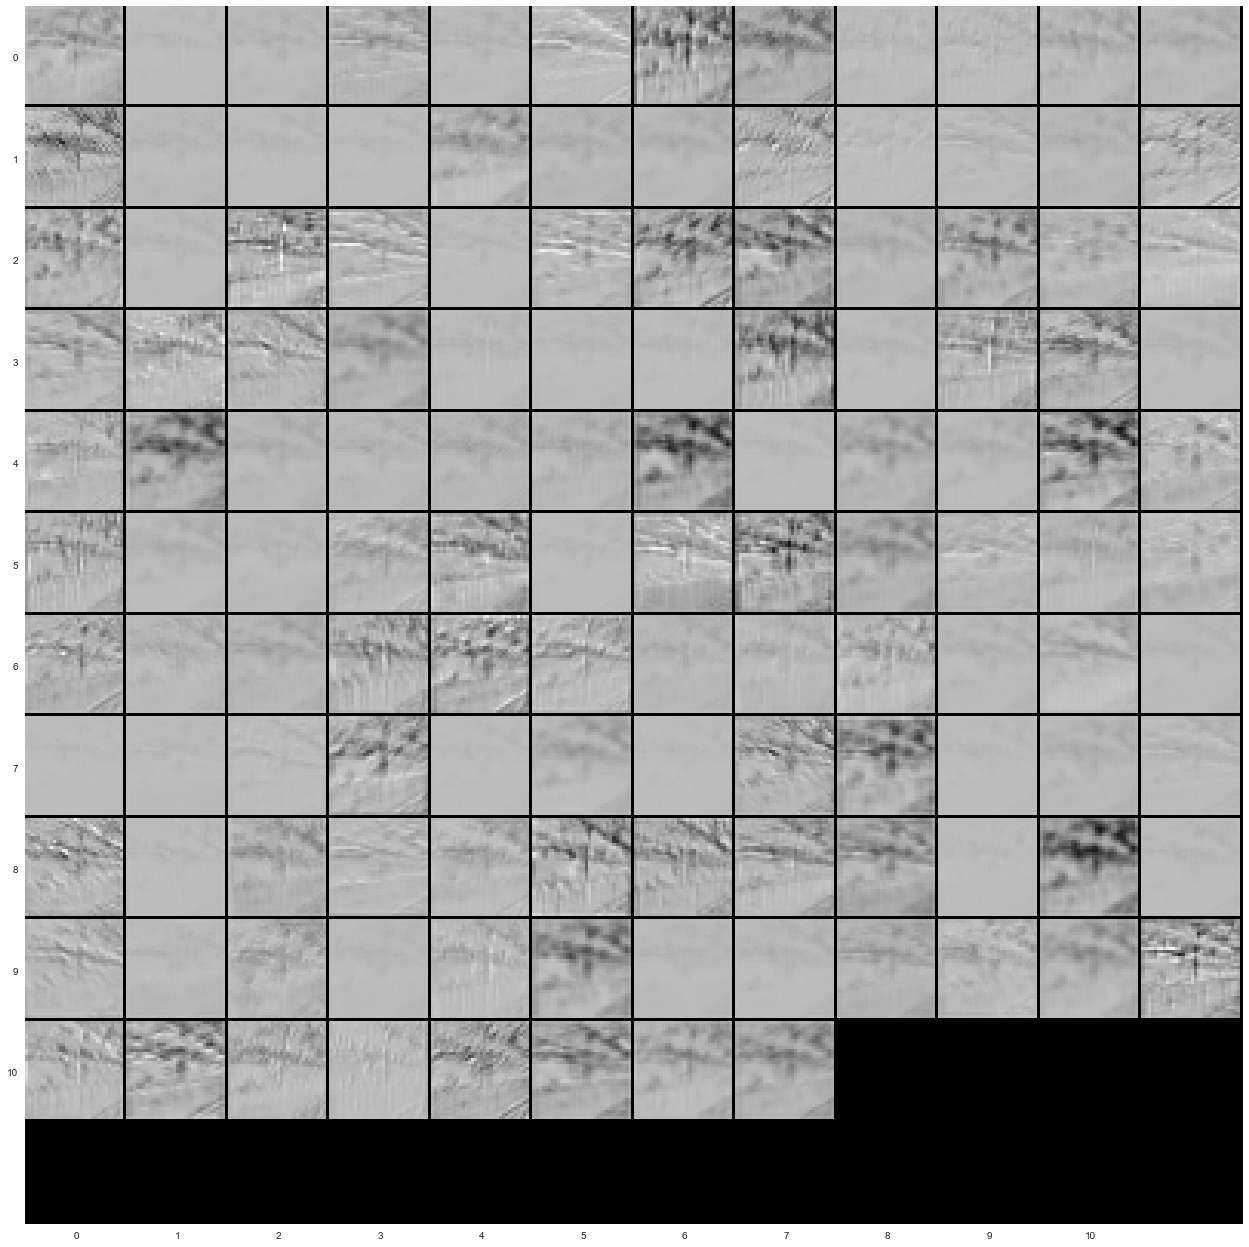

In [325]:
plt.figure(figsize=(48,48))

activ_map = vgg_c.feature_outputs[layer].data.cpu().numpy()
activ_map_shape = activ_map.shape
k_filt = activ_map_shape[1]
print(activ_map_shape)
activ_map_grid = vis_grid(activ_map, im)
vis_layer(activ_map_grid, activ_map_shape)
activ_map_shape1 = activ_map_shape[1:]
print(activ_map_shape1)

ix = np.unravel_index(activ_map[im].argsort(axis=None)[-5:], activ_map_shape1)
for i in zip(*ix):
    print("{: <22} {: <4} {: <4} {}".format(str(i), 
                                            int(i[0] % np.sqrt(k_filt)),
                                            int(i[0] / np.sqrt(k_filt)), 
                                            activ_map[im][i]))

In [326]:
activ_map = activ_map.transpose(1,2,3,0)

In [328]:
m = 119

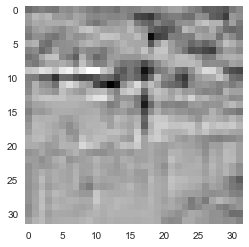

In [329]:
G=activ_map[m,:,:,im]
maxg = G.max()
ming = G.min()
G = (G - ming)/(maxg-ming)
plt.grid(False)
plt.imshow(G, cmap='gray')

In [152]:
vgg_d = vgg_deconv().cuda()

Maps in layer 3: 128
Map 119:
torch.Size([1, 3, 64, 64])


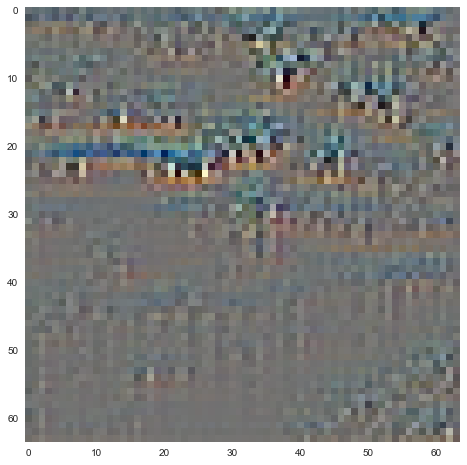

In [330]:
n_maps = activ_map.shape[0]
print("Maps in layer {}:".format(layer), n_maps)


_, map_x_dim, map_y_dim, _ = activ_map.shape
map_img_x_dim, map_img_y_dim, _ = activ_map_grid.shape
x_step = map_img_x_dim//(map_x_dim+1)


#layer = 12
x_index = 6
y_index = 0
map_idx = int(x_step*x_index + y_index)

map_idx = m

print("Map {}:".format(map_idx))

if map_idx >= n_maps:
    print('Invalid map selected')

pool_ind_single = {k:v[[im],...] for k, v in vgg_c.pool_indices.items()}


decon = vgg_d(vgg_c.feature_outputs[layer][im][map_idx][None,None,:,:], 
                layer, 
                map_idx, 
                pool_ind_single)
#decon = nn.ReLU()(decon)
print(decon.size())
#unnormalize(decon.data.cpu().numpy().squeeze())
plt.figure(figsize=(8,8))
img = decon_img(decon)
plt.grid(False)
plt.imshow(img)


In [158]:
def get_sorts(dist):
    sorts = OrderedDict()
    for i, ind in enumerate(dist.argsort(axis=None)):
        indices = np.unravel_index(ind, dist.shape)
        indices = tuple(sorted(indices, reverse=True))
        if not indices in sorts and dist[indices] != np.inf and dist[indices] != 0:
            sorts[indices] = dist[indices]
            
    return sorts

In [159]:
num_filt = vgg_c.feature_outputs[layer].data.shape[1]
decon_maps = []

In [160]:
for i in range(num_filt):
    decon = vgg_d(vgg_c.feature_outputs[layer][:, i].unsqueeze(1), layer, i, vgg_c.pool_indices).data
    decon -= decon.mean()
    decon /= decon.std()
    #decon = decon.cpu().numpy()
    decon_maps.append(decon)

In [161]:
dist = np.zeros((num_filt, num_filt), dtype=np.float32)
#num_els = float(np.prod(decon_maps.shape))

#for img in range(batchsize):
for i in range(num_filt):
    for j in range(i):
        dist[i, j] = torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)#/num_els

In [162]:
for i in range(num_filt):
    for j in range(num_filt-i):
        dist[i, i+j] = np.inf

In [163]:
top = 8
sorts = get_sorts(dist)
topsorts = OrderedDict(list(sorts.items())[:top])
topsorts

OrderedDict([((16, 11), 0.03136855),
             ((25, 14), 0.035530295),
             ((61, 33), 0.048726257),
             ((60, 25), 0.055828869),
             ((60, 14), 0.057574239),
             ((30, 16), 0.074837871),
             ((56, 17), 0.084979139),
             ((30, 11), 0.091906428)])

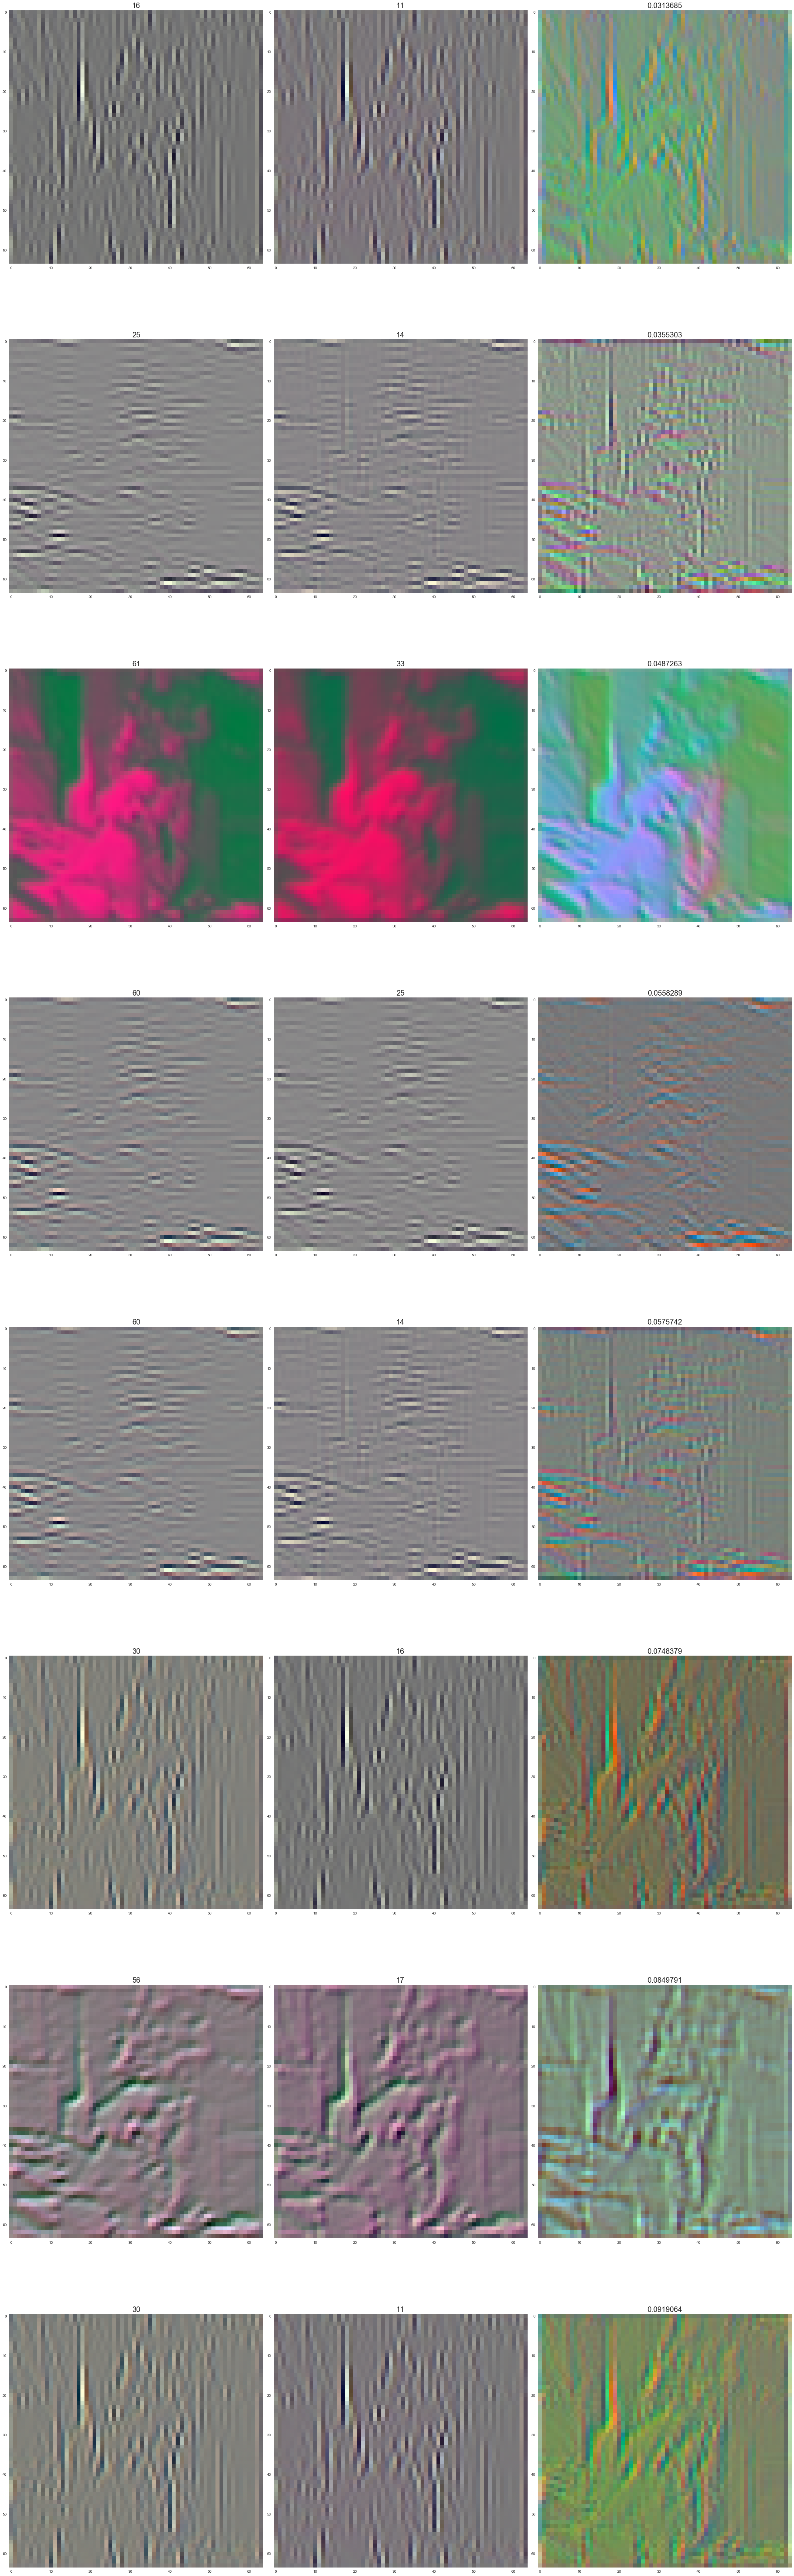

In [164]:
top = 8
f, axarr = plt.subplots(nrows=len(topsorts), ncols=3,  figsize=(30, 100))

for ind, ((i, j), diff) in enumerate(list(topsorts.items())[:top]):
    img = decon_img(decon_maps[i])
    axarr[ind, 0].set_title(str(i))
    axarr[ind, 0].title.set_fontsize(20)
    axarr[ind, 0].imshow(img)

    img = decon_img(decon_maps[j])
    axarr[ind, 1]
    axarr[ind, 1].set_title(str(j))
    axarr[ind, 1].title.set_fontsize(20)
    axarr[ind, 1].imshow(img)
    
    img = decon_img(decon_maps[i]-decon_maps[j])
    axarr[ind, 2].set_title(str(diff))
    axarr[ind, 2].title.set_fontsize(20)
    axarr[ind, 2].imshow(img)
    
    axarr[ind, 0].grid(False)
    axarr[ind, 1].grid(False)
    axarr[ind, 2].grid(False)

plt.grid(False)
plt.tight_layout()
plt.show()

In [165]:
x = list(sorts.values())

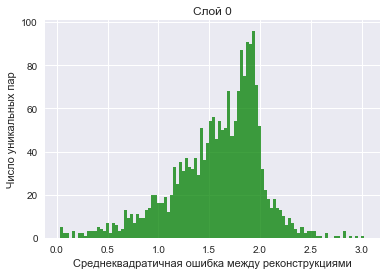

In [166]:
n, bins, patches = plt.hist(x, 100, facecolor='green', alpha=0.75)
plt.title("Слой "+str(layer))
plt.xlabel("Среднеквадратичная ошибка между реконструкциями")
plt.ylabel("Число уникальных пар")
plt.show()

In [174]:
layer_list = [0, 3, 6, 8]

In [175]:
for layer in layer_list:
    num_filt = vgg_c.feature_outputs[layer].data.shape[1]
    decon_maps = []
    
    for filt in range(num_filt):
        decon = vgg_d(vgg_c.feature_outputs[layer][:, filt].unsqueeze(1), layer, filt, vgg_c.pool_indices).data
        decon -= decon.mean()
        decon /= decon.std()
        decon_maps.append(decon)

    dist = np.zeros((num_filt, num_filt), dtype=np.float32)
    for i in range(num_filt):
        for j in range(i):
            dist[i, j] = torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)
            
    with open("reconstructions_" + str(layer) + ".npy", 'wb') as f:
        np.save(f, dist)

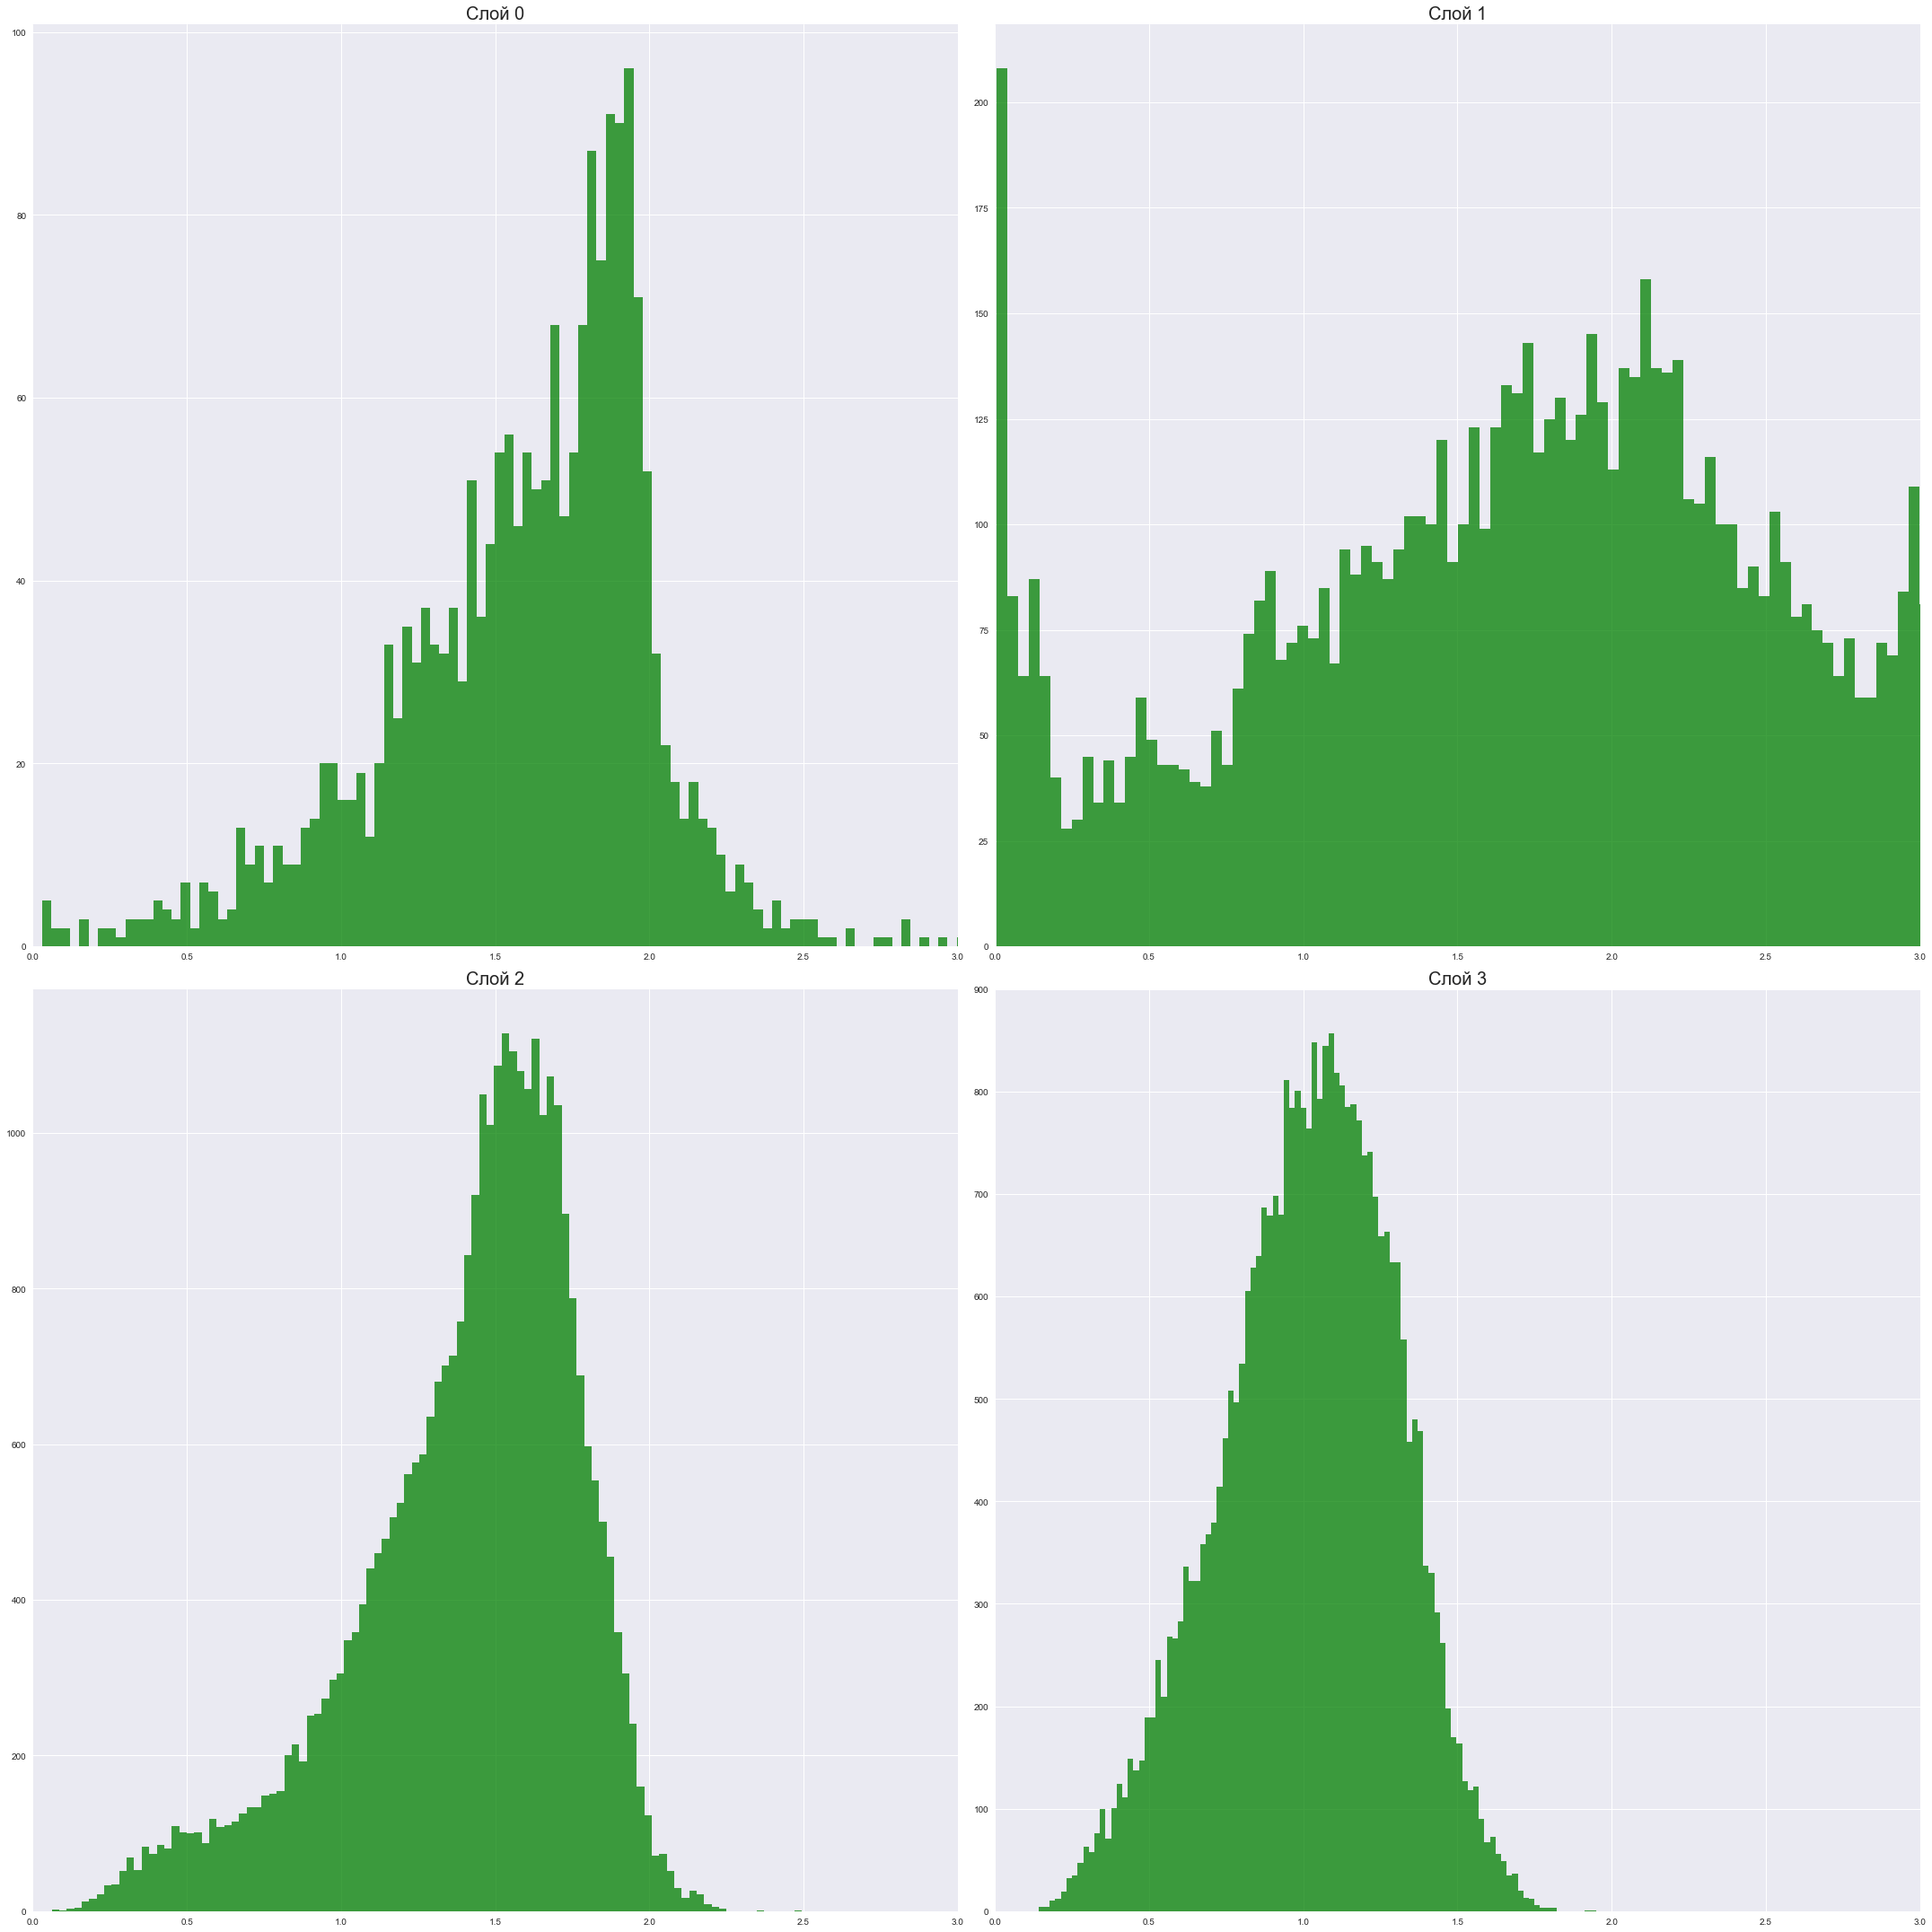

In [176]:
cols = 2
rows = len(layer_list)//cols + len(layer_list)%cols
f, axarr = plt.subplots(nrows=rows, ncols=cols,  figsize=(30, 30))

all_sorts = []

i = 0
for row in range(rows):
    for col in range(cols):
        
        dist = None
        with open("reconstructions_" + str(layer_list[i]) + ".npy", 'rb') as f:
            dist = np.load(f)
        sorts = get_sorts(dist)
        x = list(sorts.values())
        all_sorts.append(x)
        
        axarr[row, col].set_title("Слой "+str(i))
        axarr[row, col].title.set_fontsize(20)
        axarr[row, col].hist(x, 100, facecolor='green', alpha=0.75)
        axarr[row, col].set_xlim(0, 3)
        
        i += 1
        
        if i >= len(layer_list):
            break
        
plt.tight_layout()
plt.show()

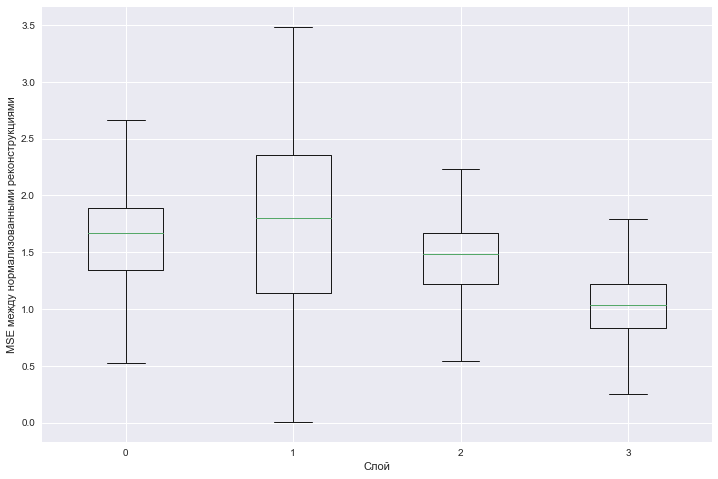

In [177]:
plt.figure(figsize=(12, 8))
plt.boxplot(all_sorts, labels=range(len(layer_list)))
plt.xlabel("Слой")
plt.ylabel("MSE между нормализованными реконструкциями")
plt.show()

In [368]:
layer_list = [0, 3, 6]

In [370]:
all_filt_means = []
for layer in layer_list:
    mean_dist_mat = None
    
    for batch_idx, batch in enumerate(train_loader):
        if batch_idx > 50:
            break
        print("layer: {} Batch {}:".format(layer, batch_idx))
        datatensor = batch[0]
        img_var = Variable(datatensor.cuda(), requires_grad=False)

        conv_out = vgg_c.forward(img_var)

        num_filt = vgg_c.feature_outputs[layer].data.shape[1]
        
        if mean_dist_mat is None:
            mean_dist_mat = np.zeros((num_filt, num_filt), dtype=np.float32)
        
        decon_maps = []

        for filt in range(num_filt):
            decon = vgg_d(vgg_c.feature_outputs[layer][:, filt].unsqueeze(1), layer, filt, vgg_c.pool_indices).data
            decon -= decon.mean()
            decon /= decon.std()
            decon_maps.append(decon)

        #dist = np.zeros((num_filt, num_filt), dtype=np.float32)
        for i in range(num_filt):
            for j in range(i):
                mean_dist_mat[i, j] += torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)
                mean_dist_mat[j, i] = mean_dist_mat[i, j]

    mean_dist_mat /= batch_idx

    filt_means = []
    for i in range(num_filt):
        filt_means.append(np.mean(mean_dist_mat[:, i]))
    all_filt_means.append(filt_means)
        
    with open("reconstructions_" + str(layer) + ".npy", 'wb') as f:
        np.save(f, mean_dist_mat)

layer: 0 Batch 0:
layer: 0 Batch 1:
layer: 0 Batch 2:
layer: 0 Batch 3:
layer: 0 Batch 4:
layer: 0 Batch 5:
layer: 0 Batch 6:
layer: 0 Batch 7:
layer: 0 Batch 8:
layer: 0 Batch 9:
layer: 0 Batch 10:
layer: 0 Batch 11:
layer: 0 Batch 12:
layer: 0 Batch 13:
layer: 0 Batch 14:
layer: 0 Batch 15:
layer: 0 Batch 16:
layer: 0 Batch 17:
layer: 0 Batch 18:
layer: 0 Batch 19:
layer: 0 Batch 20:
layer: 0 Batch 21:
layer: 0 Batch 22:
layer: 0 Batch 23:
layer: 0 Batch 24:
layer: 0 Batch 25:
layer: 0 Batch 26:
layer: 0 Batch 27:
layer: 0 Batch 28:
layer: 0 Batch 29:
layer: 0 Batch 30:
layer: 0 Batch 31:
layer: 0 Batch 32:
layer: 0 Batch 33:
layer: 0 Batch 34:
layer: 0 Batch 35:
layer: 0 Batch 36:
layer: 0 Batch 37:
layer: 0 Batch 38:
layer: 0 Batch 39:
layer: 0 Batch 40:
layer: 0 Batch 41:
layer: 0 Batch 42:
layer: 0 Batch 43:
layer: 0 Batch 44:
layer: 0 Batch 45:
layer: 0 Batch 46:
layer: 0 Batch 47:
layer: 0 Batch 48:
layer: 0 Batch 49:
layer: 0 Batch 50:
layer: 3 Batch 0:
layer: 3 Batch 1:
layer

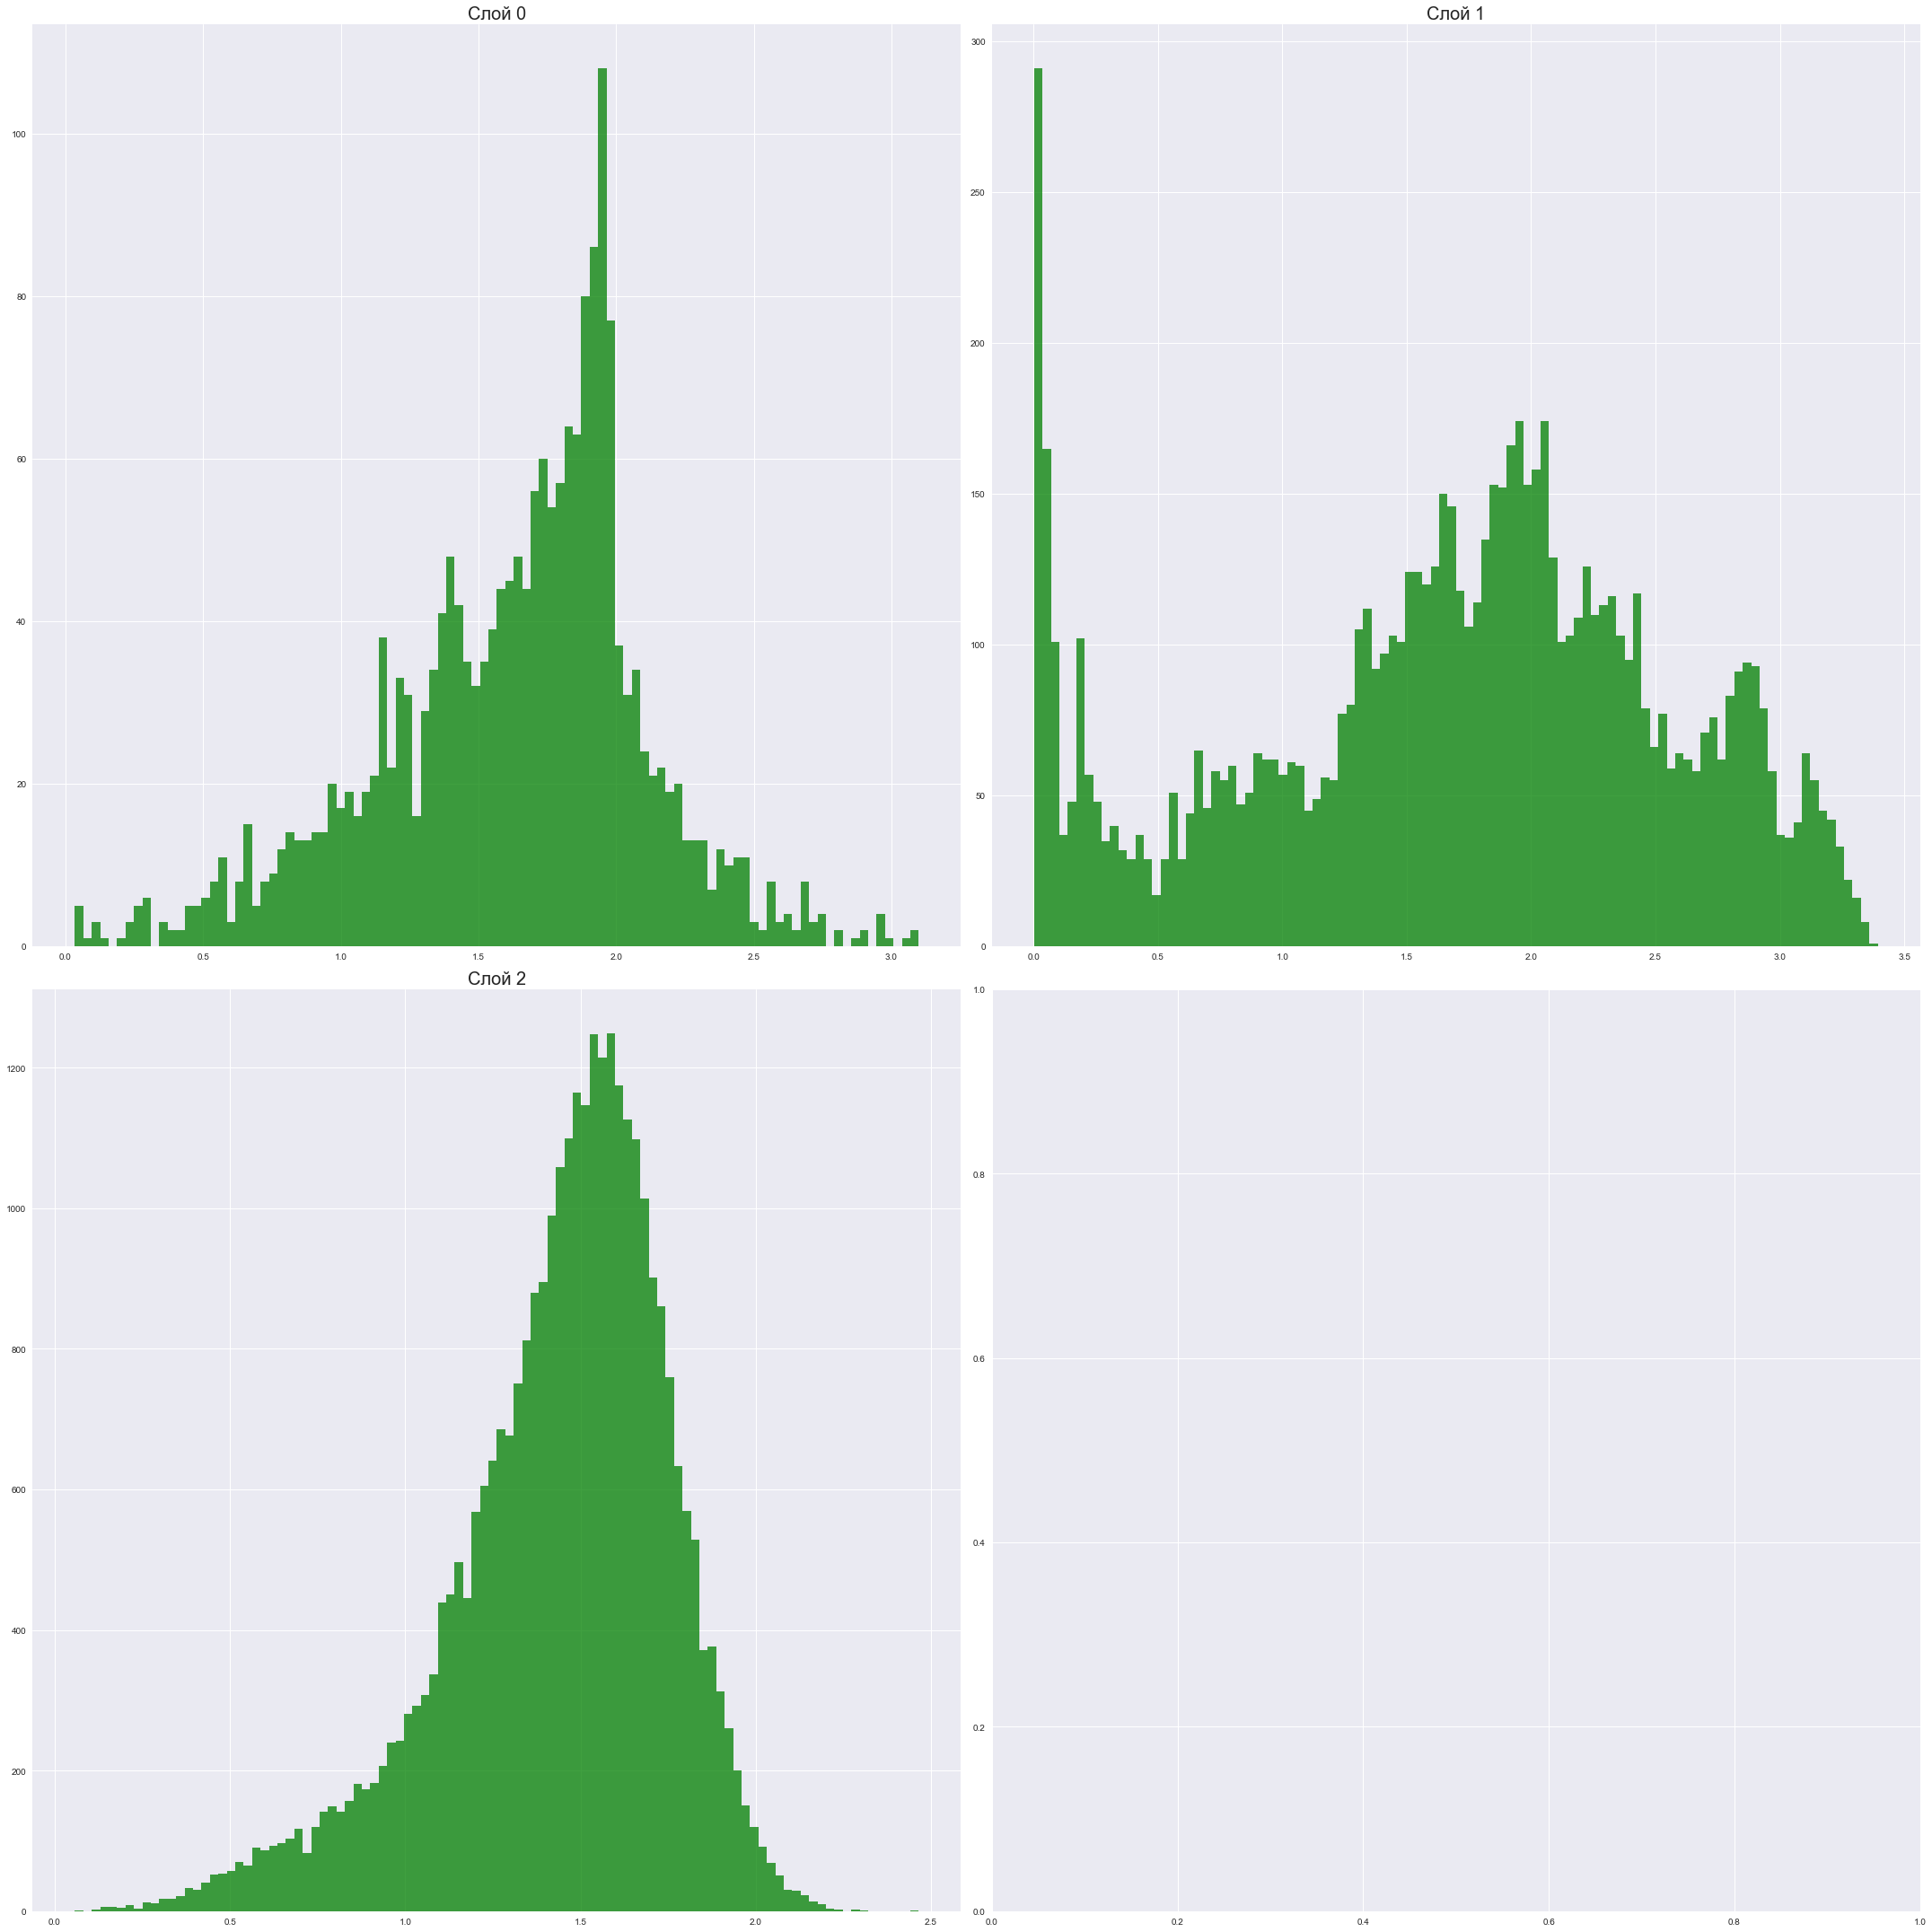

In [371]:
rows=2
cols=2

f, axarr = plt.subplots(nrows=rows, ncols=cols,  figsize=(30, 30))

all_sorts = []

i = 0
for row in range(rows):
    for col in range(cols):
        
        dist = None
        with open("reconstructions_" + str(layer_list[i]) + ".npy", 'rb') as f:
            dist = np.load(f)
        sorts = get_sorts(dist)
        x = list(sorts.values())
        all_sorts.append(x)
        
        axarr[row, col].set_title("Слой "+str(i))
        axarr[row, col].title.set_fontsize(20)
        axarr[row, col].hist(x, 100, facecolor='green', alpha=0.75)
        #axarr[row, col].set_xlim(0, 3)
        
        i += 1
        
        if i >= len(layer_list):
            break
    else:
        continue
    break
        
plt.tight_layout()
plt.show()

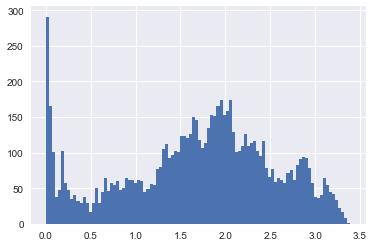

112
[  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  25  26  28  29  30  31  32  33  35  36  37  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  61
  62  64  65  66  67  68  69  70  72  73  74  75  76  78  79  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 109 111 112 113 114 115 116 118 119 121 122 123
 124 125 126 127]
[(84, 1), (90, 84), (93, 65), (93, 90), (93, 55), (65, 55), (93, 84), (90, 1), (14, 1), (97, 93), (111, 83), (84, 14), (88, 15), (97, 55), (90, 65), (88, 1), (90, 55), (93, 1), (65, 1), (90, 14), (65, 14), (84, 65), (42, 1), (90, 88), (88, 84), (84, 55), (15, 1), (93, 14), (111, 65), (93, 83), (93, 88), (88, 14), (97, 65), (65, 15), (83, 65), (88, 65), (111, 55), (97, 90), (90, 83), (107, 41), (55, 14), (90, 15), (15, 14), (105, 88), (93, 85), (111, 93), (85, 83), (93, 15), (105, 84), (84, 15), (111, 85), (107, 14), (114, 111), (93, 2

In [527]:
dist = None
with open("reconstructions_3.npy", 'rb') as f:
    dist = np.load(f)
sorts = get_sorts(dist)
sorts_list = list(sorts)
x = list(sorts.values())

_, bins, _ = plt.hist(x, 100)
plt.show()
ind = np.digitize(x, bins)
rem_bins =range(1, 25)
rem = []
for i in range(len(x)):
    #print(i, x[i], '-', ind[i], sorts_list[i])
    if ind[i] in rem_bins:
        rem.append(sorts_list[i])
rem_uniq = np.unique(rem)
print(len(rem_uniq))
print(rem_uniq)
print(rem)

0.7029837388224143


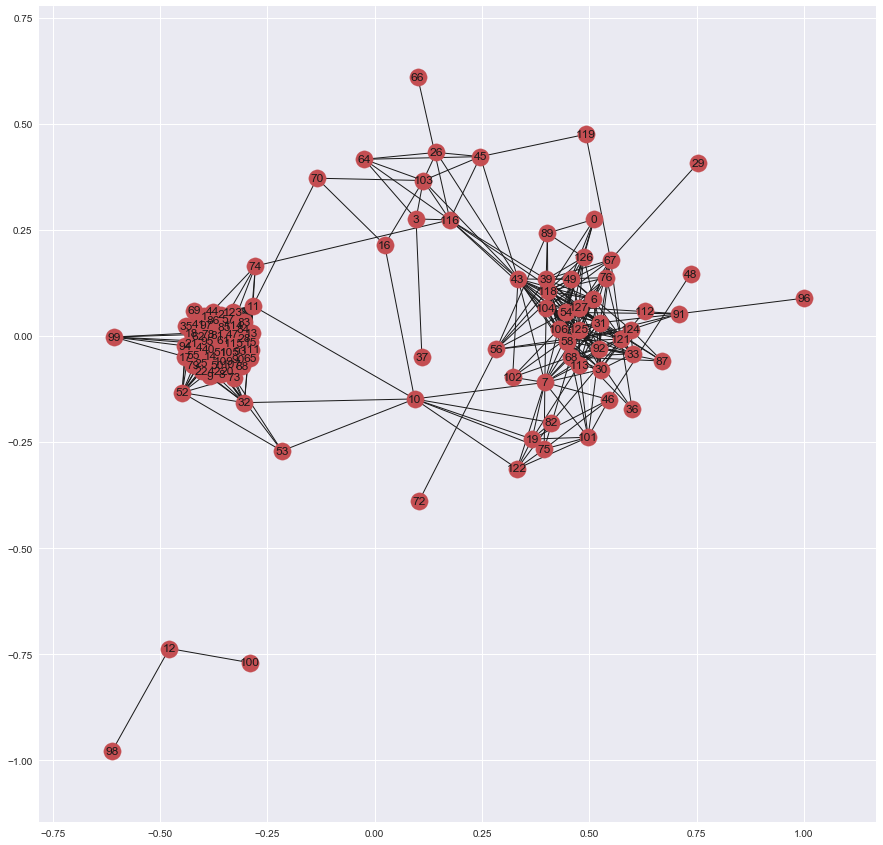

In [528]:
import networkx as nx

G=nx.Graph()
G.add_nodes_from(rem_uniq)

for edge in rem:
    G.add_edge(*edge)

#print("Nodes of graph: ")
#print(G.nodes())
#print("Edges of graph: ")
#print(G.edges())

print(nx.average_clustering(G))

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G,k=0.15,iterations=30)
nx.draw_networkx(G, pos)
#plt.savefig("simple_path.png") # save as png
plt.show() # display

In [529]:
n_filters = 128

[0.51009071, 0.45498231, 0.43745694, 0.42212889, 0.4141286, 0.42685568, 0.41075245, 0.40306851, 0.43615821, 0.43060344, 0.42359915, 0.42579687, 0.42441756, 0.42120981, 0.41672584, 0.40436545, 0.40321016, 0.40089968, 0.39556473, 0.3903546, 0.38013256, 0.37229049, 0.36777222, 0.37893912, 0.40433252, 0.40059492, 0.39834717, 0.39499882, 0.39306247, 0.39144903, 0.38783616, 0.38701338, 0.3845942, 0.38269234, 0.38759968, 0.37438962, 0.36907744, 0.36769468, 0.36240059, 0.36496001, 0.36598188, 0.35923985, 0.36227879, 0.36100158, 0.36588883, 0.3656171, 0.36233142, 0.3675456, 0.36900398, 0.36481684, 0.36147746, 0.35880572, 0.35585642, 0.35096347, 0.34789196, 0.34483987, 0.3388727, 0.33453515, 0.32963449, 0.32606339, 0.32075617, 0.31880128, 0.31470391, 0.3138997, 0.31405985, 0.31113148, 0.30826509, 0.30310929, 0.29954663, 0.30338621, 0.29849952, 0.29478598, 0.26736093, 0.26465577, 0.26051742, 0.26163292, 0.25818446, 0.26004153, 0.25270763, 0.24850048, 0.24386445, 0.24266985, 0.23958975, 0.2376489,

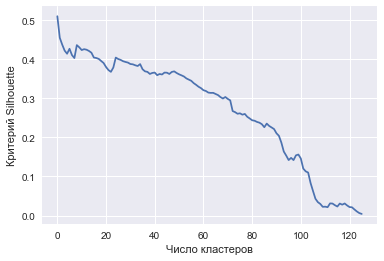

In [530]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

vals = []
lbls = {}
for n_clusters in range(2, n_filters):
    cl = AgglomerativeClustering(n_clusters, affinity='precomputed', linkage='average')
    y = cl.fit_predict(dist)
    lbls[n_clusters] = y
    #print(y)
    score = silhouette_score(dist, y, metric='precomputed')
    vals.append(score)
    
print(vals, max(vals), np.argmax(vals))
plt.plot(vals)
plt.ylabel("Критерий Silhouette")
plt.xlabel("Число кластеров")
plt.show()

In [523]:
n_clusters = 28
cl = AgglomerativeClustering(n_clusters)
y = cl.fit_predict(dist)
lbls[n_clusters] = y
#print(y)
score = silhouette_score(dist, y)
print(score)

0.338922


/home/lestsovba/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [524]:
clusters = []
filters_to_keep = []
for i in range(n_filters):
    lbl = lbls[n_clusters][i]
    if not lbl in clusters:
        clusters.append(lbl)
        filters_to_keep.append(i)
print(filters_to_keep, len(filters_to_keep))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 17, 18, 19, 21, 23, 24, 26, 28, 29, 33, 36, 44, 47, 49, 57] 28


In [453]:
keepdist = OrderedDict()
keepdistmat = np.zeros(shape=(len(filters_to_keep), len(filters_to_keep)))
for i in range(len(filters_to_keep)):
    for j in range(i+1):
        keepdist[(i, j)] = dist[(i,j)]
        keepdistmat[i, j] = dist[i,j]
rem = list(get_sorts(keepdistmat).keys())


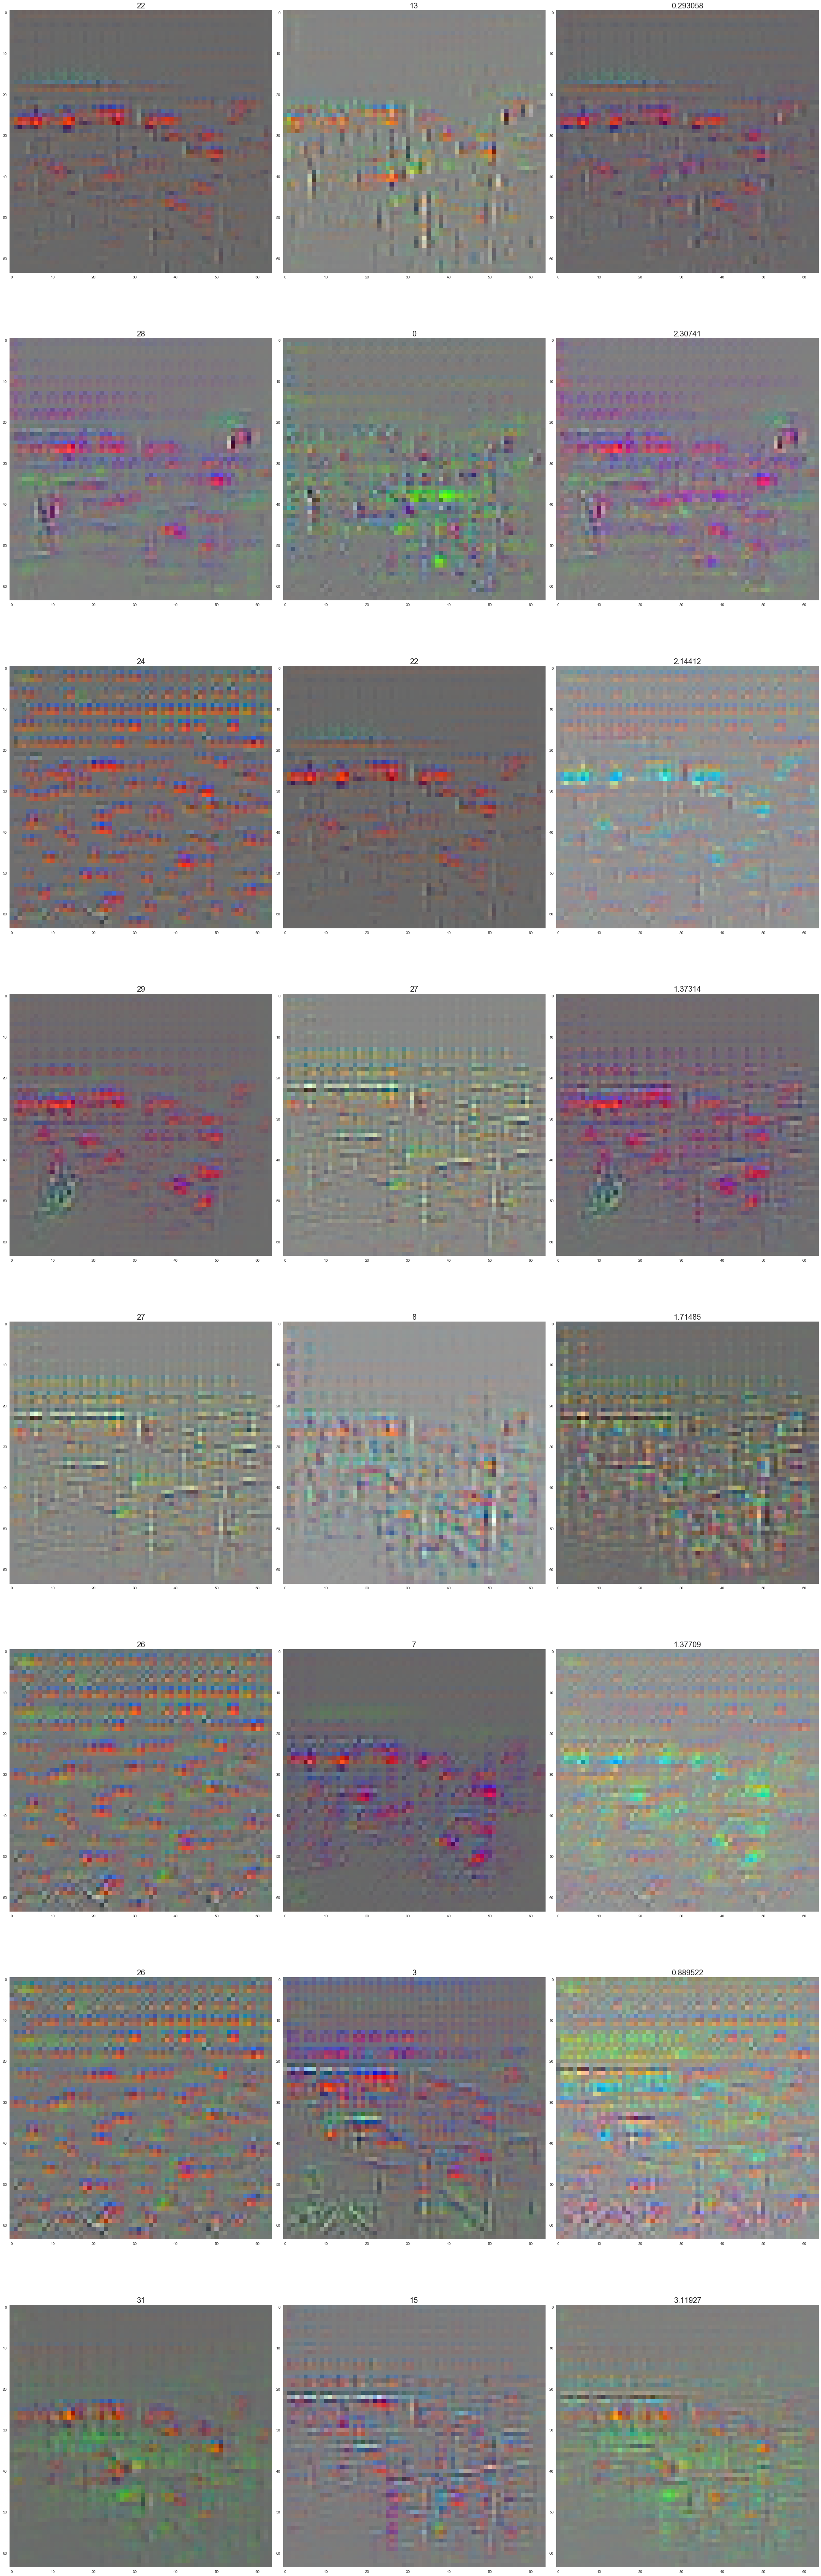

In [454]:
top = 8
f, axarr = plt.subplots(nrows=top, ncols=3, figsize=(30, top*12))

np.random.shuffle(rem)
for ind, (i, j) in enumerate(rem[:top]):
    diff = sorts[(i,j)]
    #decon_i = decon_maps[i].mean(dim=0, keepdim=True)
    #decon_j = decon_maps[j].mean(dim=0, keepdim=True)
    
    decon_i = decon_maps[i][3,...].unsqueeze(0)
    decon_j = decon_maps[j][3,...].unsqueeze(0)
    
    img = decon_img(decon_i)
    axarr[ind, 0].set_title(str(i))
    axarr[ind, 0].title.set_fontsize(20)
    axarr[ind, 0].imshow(img)

    img = decon_img(decon_j)
    axarr[ind, 1]
    axarr[ind, 1].set_title(str(j))
    axarr[ind, 1].title.set_fontsize(20)
    axarr[ind, 1].imshow(img)
    
    img = decon_img(decon_i-decon_j)
    axarr[ind, 2].set_title(str(diff))
    axarr[ind, 2].title.set_fontsize(20)
    axarr[ind, 2].imshow(img)
    
    axarr[ind, 0].grid(False)
    axarr[ind, 1].grid(False)
    axarr[ind, 2].grid(False)

plt.grid(False)
plt.tight_layout()
plt.show()